## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
from pymystem3 import Mystem
m = Mystem()

In [3]:
pd.set_option('display.float_format', '{:.2f}'.format)
data = pd.read_csv('/datasets/data.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [5]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.67,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.64,покупка жилья
1,1,-4024.80,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.01,приобретение автомобиля
2,0,-5623.42,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.95,покупка жилья
3,3,-4124.75,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.55,дополнительное образование
4,0,340266.07,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.08,сыграть свадьбу


In [6]:
data.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.00,19351.00,21525.00,21525.00,21525.00,21525.00,19351.00
mean,0.54,63046.50,43.29,0.82,0.97,0.08,167422.30
std,1.38,140827.31,12.57,0.55,1.42,0.27,102971.57
min,-1.00,-18388.95,0.00,0.00,0.00,0.00,20667.26
25%,0.00,-2747.42,33.00,1.00,0.00,0.00,103053.15
50%,0.00,-1203.37,42.00,1.00,0.00,0.00,145017.94
75%,1.00,-291.10,53.00,1.00,1.00,0.00,203435.07
max,20.00,401755.40,75.00,4.00,4.00,1.00,2265604.03


In [7]:
data.duplicated().sum()

54

### Вывод

Входные данные состоят из **21525** записей по клиентам, характеристики клиентов распределены по 12 столбцам:

* `children` — количество детей в семье
* `days_employed` — трудовой стаж в днях
* `dob_days` — возраст клиента в годах
* `education` — образование клиента
* `education_id` — идентификатор образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — доход в месяц
* `purpose` — цель получения кредита

Столбцы `days_employed` и `total_income` содержат не полный набор записей (**2174** значения пропущены в обеих таблицах, что составляет около **10%** всех записей). В чем именно может быть причина пропусков проанализируем далее.

Тип данных столбца не соответствует сущности величины трудового стажа в днях. Поскольку дни являются целочисленным значением, использование для этой величины типа `float` выглядит не вполне уместным. Тип данных дохода в месяц также удобнее было бы анализировать в целочисленном виде, а не вещественном, как на данный момент в выгрузке.

### Шаг 2. Предобработка данных

### Обработка пропусков

Были обнаружены пропуски значений в колонках с данными о трудовом стаже клиента и доходу в месяц. Убедимся, что пропуски в обеих колонках присутствуют на одних и тех же строках.

In [8]:
# отфильтруем входные данные - оставим только строки с пропусками в стаже
data[data['days_employed'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 12 to 21510
Data columns (total 12 columns):
children            2174 non-null int64
days_employed       0 non-null float64
dob_years           2174 non-null int64
education           2174 non-null object
education_id        2174 non-null int64
family_status       2174 non-null object
family_status_id    2174 non-null int64
gender              2174 non-null object
income_type         2174 non-null object
debt                2174 non-null int64
total_income        0 non-null float64
purpose             2174 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 220.8+ KB


Видим, что в отфильтрованном по отсутствующим значениям стажа датафрейме, доход также не содержит ни одной записи, соответственно, все пропущенные значения по стажу находятся на тех же строках, что и отсутствующие значения по доходу.

Это может быть связано с тем, что клиент вообще не работает или не работает по найму и, соответственно, не имеет стажа в общем понимании и официальной зарплаты, например, пенсионер или самозанятый, или имеет какую-то специфику в своем типе занятости, например, работает неофициально.

In [9]:
# Посмотрим, какие типы занятости есть у клиентов с отсутствующими значениями стажа и дохода
data[data['days_employed'].isna()]['income_type'].value_counts()

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

In [10]:
# Посмотрим количество всех клиентов, распределенных по типам их занятости
data['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64

Получается, почти у **10%** всех клиентов **не указан стаж и доход** в каждой из групп типа занятости (не считая совсем малочисленных). Это значительная величина, необходимо сделать замену пропущенных значений. 
Для начала рассмотрим подробнее данные по стажу.

In [11]:
# значения по стажу
data['days_employed'].value_counts().head()

-986.93     1
-7026.36    1
-4236.27    1
-6620.40    1
-1238.56    1
Name: days_employed, dtype: int64

Значения стажа не повторяются, посмотрим минимальное и максимальное значения. 

In [12]:
print('Минимальный стаж: {:.2f}'.format(data['days_employed'].min()))
print('Максимальный стаж: {:.2f}'.format(data['days_employed'].max()))

Минимальный стаж: -18388.95
Максимальный стаж: 401755.40


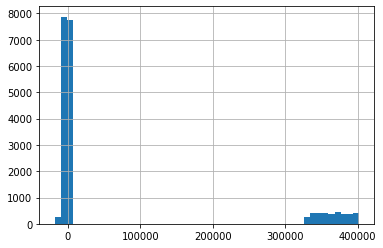

In [13]:
data['days_employed'].hist(bins=50)

Среди значений по стажу присутствуют как положительные, так и отрицательные значения. Отрицательные значения стажа не имеют смысла, посмотрим насколько много таких значений, не является ли это случайной ошибкой.

In [14]:
# группируем по стажу
def days_employed_group(days_employed):
    try:
        if days_employed < 0:
            return 'отрицательный'
        elif days_employed >= 0:
            return 'положительный'
        return 'NAN'
    except: 'проверьте передаваемые значения'

data['days_employed_group'] = data['days_employed'].apply(days_employed_group)
data['days_employed_group'].value_counts()

отрицательный    15906
положительный     3445
NAN               2174
Name: days_employed_group, dtype: int64

Количество отрицательных значений указывает на то, что это не случайная ошибка. Попробуем выяснить, в чем нюанс, построив сводную таблицу и соотнеся данные по отрицательному/положительному стажу и типам занятости.

In [15]:
data_pivot_income_vs_employed_group = data.pivot_table(index=['days_employed_group'], columns='income_type', values='children', aggfunc='count') 
data_pivot_income_vs_employed_group

income_type,безработный,в декрете,госслужащий,компаньон,пенсионер,предприниматель,сотрудник,студент
days_employed_group,,,,,,,,
NAN,nan,nan,147.00,508.00,413.00,1.00,1105.00,nan
отрицательный,nan,1.00,1312.00,4577.00,nan,1.00,10014.00,1.00
положительный,2.00,nan,nan,nan,3443.00,nan,nan,nan


Видим, что положительный стаж только у неработающих клиентов - пенсионеров и безработных. Отрицательный стаж же напротив у работающих - сотрудников, госслужащих и компаньонов. Возможно, это специфика хранения данных в системе, откуда производилась выгрузка.

In [16]:
# вычислим среднее значение стажа и заполним пропущенные значения стажа
days_employed_mean = data['days_employed'].mean()
data['days_employed'] = data['days_employed'].fillna(days_employed_mean)

Посмотрим, какие уникальные значения есть в целевых для анализа столбцах и нет ли явных проблем с другими данными

In [17]:
# значения по семейному положению
data['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

In [18]:
# значения по количеству детей
data['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Среди данных по количеству детей встречаются отрицательные значения, что противоречит здравому смыслу. Вероятнее всего это ошибка, вызванная человеческим фактором, заменим значения "-1" на "1". Также встречается значение "20", такое количество детей это довольно маловероятно для одного человека, особенно когда таких записей 76 штук, скорее всего здесь также имеет место человеческий фактор и 0 лишний, поменяем значение "20" на "2".

In [19]:
data.loc[data['children'] == -1, 'children'] = 1
data.loc[data['children'] == 20, 'children'] = 2
data['children'].value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

Посмотрим другие столбцы на корректность предоставленных данных

In [20]:
# значения по возрасту
data['dob_years'].unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75])

В списке возрастов присутствует значение "0", что указывает на то, что данные не были заполнены. Так как какой-либо дополнительной информацией для устранения данного пропуска мы не обладаем, а данные не являются целевыми, оставим значение "0".

In [21]:
# значения по образованию
data['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

Среди наименований уровня образования есть разночтения в написании, необходимо будет привести к единообразию, оставив категории: начальное, среднее, неоконченное высшее, высшее, ученая степень

In [22]:
# значения по семейному статусу
data['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

In [23]:
# значения по полу
data['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

В списке гендеров присутствует один артефакт, поскольку такое значение всего одно, удалим его из выгрузки.

In [24]:
# найдем индекс строки с артефактом
data[data.gender == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,days_employed_group
10701,0,-2358.60,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.16,покупка недвижимости,отрицательный


In [25]:
# удаляем строку с артефактом
data= data.drop(data.index[10701])

In [26]:
# значения по флагу наличия задолженности по возврату кредита
data['debt'].value_counts()

0    19783
1     1741
Name: debt, dtype: int64

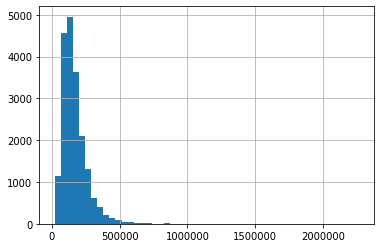

In [27]:
# значения по доходу
data['total_income'].hist(bins=50)

Заменим пропущенные значения средней величиной, т.к. информация столбца не является целевой для текущего анализа 

In [28]:
# вычислим среднее значение дохода и сделаем замену пропущенных значений в data
total_income_mean = data['total_income'].mean()
data['total_income'] = data['total_income'].fillna(total_income_mean)

In [29]:
# значения по цели
data['purpose'].value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
операции с жильем                         653
покупка жилья для сдачи                   653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      623
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Среди целей кредита много синонимов, необходимо в дальнейшем провести их лемматизацию и унифицировать.

### Вывод

Целевой показатель анализа платежеспособности клиентов - **количество детей - содержал некорректные данные**, появившиеся в выгрузке, вероятнее всего, из-за человеческого фактора. Противоречащие здравому смыслу значения (отрицательные и слишком большие для количества детей на одного человека) были заменены на ближайшие по смыслу.

Среди данных у некоторых клиентов **не было информации стаж - доход**, что могло быть связано со спецификой занятости таких клиентов и отсутствием официально подтвержденных данных стажа и дохода, либо с вносимыми корректировками в систему и отображением обновленной информации в качестве новой строки (ведь мы увидели некорректные данные, например, отрицательные значения количества детей, и возможна такая ситуация, когда из системы выгружается 2 строки по одному клиенту в случае вносимых изменений в систему - до корректировок и после, но в одной из строк часть информации теряется). Доля клиентов с пропусками составила около **10%**, что является значительной величиной и такую информацию необходимо добавить для формирования полного объема входных данных. Однако в силу того, что категории с пропущенными величинами не являются целевыми для проведения анализа платежеспособности клиентов, данные для замены могут быть весьма условными, поэтому в качестве данных для замены были выбраны средние величины стажа и дохода по всем клиентам выгрузки.

Среди значений по стажу присутствуют как положительные, так и отрицательные значения, положительный стаж у неработающих клиентов, отрицательный - у работающих. Возможно, это специфика хранения данных в системе.

В данных распределения по полу удалена строка с артефактом.

При первичном анализе данных также было обнаружено, что в наименовании категорий уровня образования есть разные варианты написания, по своей сути это повторы, необходимо будет привести их к единообразию. Среди категорий целей кредитования также много синонимов, в таком виде анализировать их довольно трудоемко и неудобно, поэтому необходимо будет лемматизировать список целей кредита для их унификации и возможности проведения анализа.

### Замена типа данных

Как уже было указано, тип данных столбца с информацией о трудовом стаже в днях некорректен, необходимо данные вещественного типа привести к целочисленному типу. Данные столбца с доходм также приведем к целым значениям для удобства дальнейшего анализа.

Так как у столбцов `days_employed` и `total_income` текущий тип данных `float`, а целевой тип данных `int`, т.е. оба являются численными, метод преобразования типов данных `to_numeric()` нам не подходит. Совершим преобразование с помощью метода `astype(int)`.

In [30]:
data['days_employed'] = data['days_employed'].astype(int)
data['total_income'] = data['total_income'].astype(int)
data.dtypes

children                int64
days_employed           int64
dob_years               int64
education              object
education_id            int64
family_status          object
family_status_id        int64
gender                 object
income_type            object
debt                    int64
total_income            int64
purpose                object
days_employed_group    object
dtype: object

### Вывод

Показатель стажа в днях теперь имеет целочисленный тип данных, что отражает смысл хранимого в данном столбце показателя. Показатель дохода также приведен к целочисленному типу для удобства работы с ним в ходе проведения анализа.

### Обработка дубликатов

Ранее было отмечено, что столбец `education` содержит разное написание одних и тех же категорий. Приведем к единообразию написание категорий уровня образования, используя метод `str.lower()`

In [31]:
data['education'] = data['education'].str.lower()
data['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      743
начальное                282
ученая степень             6
Name: education, dtype: int64

Проверим наличие идентичных строк в датафрейме с помощью метода duplicated(), а сами дубликаты при наличии удалим методом drop_duplicates, т.к. он удаляет повторяющиеся строки и возвращает сам датафрейм.

In [32]:
data.duplicated().value_counts()

False    21453
True        71
dtype: int64

In [33]:
data = data.drop_duplicates()
len(data)

21453

### Вывод

В данных была обнаружена **71 полностью дублирующаяся строка**, что составляет около **0,3%** всех записей из первоначальной выгрузки, это небольшой процент, и эти строки мы удалили для предотвращения искажения итогового результата. 

Возможно, некоторые клиенты получали несколько кредитов на одинаковые цели на коротком промежутке времени, что является не слишком распространенной ситуацией, но и не совсем невероятной. Другое предположение состоит в том, что дубликаты могли появиться после того, как мы привели не имеющие смысла значения к корректным (например, отрицательные значения по количеству детей), а в наборе уже присутствовала строка с корректными данными, выгруженная из системы, и тем самым появились полностью одинаковые строки, которые ранее различались на некорректно введенное значение и исправленное в системе значение.

Также были приведены к единому формату данные, описывающие уровень образования клиентов (убраны дубликаты с разночтением в написании имени категории).

### Лемматизация

При первичном анализе мы увидели, что среди целей кредитования много синонимов и приняли решение лемматизировать список целей кредита для их унификации. Проведем лемматизацию с помощью инструментов библиотеки pymystem3.

In [34]:
# найдем количество всех уникальных целей кредитования, указанных в выгрузке
data['purpose'].value_counts().count()

38

Ранее мы проанализировали все возможные цели кредита, которые были представлены в выгрузке, среди них оказалось всего 38 уникальных, но и они по смыслу во многом пересекаются между собой. Посмотрим еще раз на список целей и сохраним их в отдельную переменную, чтобы унифицировать их.

In [35]:
purpose_dict = data['purpose'].unique()
purpose_dict

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Проведем лемматизацию уникальных значений целей кредитования

In [36]:
purpose_string = ' '.join(purpose_dict)
lemmas = m.lemmatize(purpose_string)
print(lemmas)

['покупка', ' ', 'жилье', ' ', 'приобретение', ' ', 'автомобиль', ' ', 'дополнительный', ' ', 'образование', ' ', 'сыграть', ' ', 'свадьба', ' ', 'операция', ' ', 'с', ' ', 'жилье', ' ', 'образование', ' ', 'на', ' ', 'проведение', ' ', 'свадьба', ' ', 'покупка', ' ', 'жилье', ' ', 'для', ' ', 'семья', ' ', 'покупка', ' ', 'недвижимость', ' ', 'покупка', ' ', 'коммерческий', ' ', 'недвижимость', ' ', 'покупка', ' ', 'жилой', ' ', 'недвижимость', ' ', 'строительство', ' ', 'собственный', ' ', 'недвижимость', ' ', 'недвижимость', ' ', 'строительство', ' ', 'недвижимость', ' ', 'на', ' ', 'покупка', ' ', 'подержать', ' ', 'автомобиль', ' ', 'на', ' ', 'покупка', ' ', 'свой', ' ', 'автомобиль', ' ', 'операция', ' ', 'с', ' ', 'коммерческий', ' ', 'недвижимость', ' ', 'строительство', ' ', 'жилой', ' ', 'недвижимость', ' ', 'жилье', ' ', 'операция', ' ', 'со', ' ', 'свой', ' ', 'недвижимость', ' ', 'автомобиль', ' ', 'заниматься', ' ', 'образование', ' ', 'сделка', ' ', 'с', ' ', 'подержать

Посчитаем количество вхождений каждой леммы и определим унифицированные цели кредитов

In [37]:
from collections import Counter
print(Counter(lemmas))

Counter({' ': 96, 'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'с': 5, 'операция': 4, 'на': 4, 'свой': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'жилой': 2, 'подержать': 2, 'заниматься': 2, 'сделка': 2, 'приобретение': 1, 'сыграть': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'со': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1, '\n': 1})


Среди лемм наиболее часто встречающиеся цели кредита - это "недвижимость", "автомобиль", "образование", "жилье" и "свадьба", и не очень популярный, но все же выделим его отдельно - "ремонт". Недвижимость и жилье по своей сути являются синонимами, особенно "жилая недвижимость", поэтому эти две леммы соединим в одну - "недвижимость".

Создадим словарь соответствия уникальных значений целей и лемм.

In [38]:
columns = ['purpose', 'lemmas_list']
lemmas_dict = pd.DataFrame(columns=columns)
lemmas_dict['purpose'] = purpose_dict
lemmas_dict['lemmas_list'] = lemmas_dict['purpose'].apply(m.lemmatize)

lemmas_dict.head()

,purpose,lemmas_list
0,покупка жилья,"[покупка, , жилье, \n]"
1,приобретение автомобиля,"[приобретение, , автомобиль, \n]"
2,дополнительное образование,"[дополнительный, , образование, \n]"
3,сыграть свадьбу,"[сыграть, , свадьба, \n]"
4,операции с жильем,"[операция, , с, , жилье, \n]"


Унифицируем цели кредитования с помощью найденных лемм, учитывая наличие синонимов

In [39]:
def find_lemma(lemmas_list):
    if 'ремонт' in lemmas_list:
        return 'Кредит на ремонт'
    if 'недвижимость' in lemmas_list:
        return 'Кредит на приобретение недвижимости'
    elif 'автомобиль' in lemmas_list:
        return 'Автокредит'
    elif 'образование' in lemmas_list:
        return 'Кредит на образование'
    elif 'жилье' in lemmas_list:
        return 'Кредит на приобретение недвижимости'
    elif 'свадьба' in lemmas_list:
        return 'Кредит на свадьбу'
    

lemmas_dict['lemma'] = lemmas_dict['lemmas_list'].apply(find_lemma)
lemmas_dict.drop(['lemmas_list'], axis='columns', inplace=True)
lemmas_dict.tail()

,purpose,lemma
33,высшее образование,Кредит на образование
34,покупка жилья для сдачи,Кредит на приобретение недвижимости
35,на покупку автомобиля,Автокредит
36,ремонт жилью,Кредит на ремонт
37,заняться высшим образованием,Кредит на образование


In [40]:
# Добавим цели кредита, выделенные из лемм, к изначальным данным.
data = data.merge(lemmas_dict)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21453 entries, 0 to 21452
Data columns (total 14 columns):
children               21453 non-null int64
days_employed          21453 non-null int64
dob_years              21453 non-null int64
education              21453 non-null object
education_id           21453 non-null int64
family_status          21453 non-null object
family_status_id       21453 non-null int64
gender                 21453 non-null object
income_type            21453 non-null object
debt                   21453 non-null int64
total_income           21453 non-null int64
purpose                21453 non-null object
days_employed_group    21453 non-null object
lemma                  21453 non-null object
dtypes: int64(7), object(7)
memory usage: 2.5+ MB


In [41]:
# Выведем итогвую таблицу с распределением всех значений в выгрузке по целям кредитования
lemmas_table = data['lemma'].value_counts().reset_index()
lemmas_table.columns = ['lemma', 'quantity']
sum = lemmas_table['quantity'].sum()
lemmas_table['percent'] = lemmas_table['quantity'] / sum * 100
lemmas_table

,lemma,quantity,percent
0,Кредит на приобретение недвижимости,10203,47.56
1,Автокредит,4306,20.07
2,Кредит на образование,4013,18.71
3,Кредит на свадьбу,2324,10.83
4,Кредит на ремонт,607,2.83


### Вывод

Столбец с целями по кредитованию в выгрузке содержал множество смысловых повторов, что затрудняло понимание какие цели кредитования являются наиболее востребованными. С помощью лемматизации были выделены **5 основных целей кредитов** ("недвижимость", "автомобиль", "образование", "ремонт" и "свадьба"). Самый популярный вид кредитования связан с приобретением недвижимости, его доля составляет чуть менее половины всех записей выгрузки (47,5%), далее идут покупка авто и образование, на них приходится 20% и 19% выбоки соответственно. 11% клиентов берут кредит на свадьбу и еще около 3% на ремонт.

### Категоризация данных

Среди данных в таблице присутствует информация с распределением всех клиентов по категориям, причем в `data` есть как словесное название категории, так и ее id. Эту информацию удобнее было бы выделить в отдельные словари, где названию категории будет соответствовать номер. Создадим словарь с данными об образовании и словарь с данными о семейном положении.

In [42]:
# создаем словарь education
education_dict = data[['education','education_id']]
education_dict = education_dict.drop_duplicates().reset_index(drop=True)
education_dict

,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


In [43]:
# создаем словарь family_status
family_status_dict = data[['family_status','family_status_id']]
family_status_dict = family_status_dict.drop_duplicates().reset_index(drop=True)
family_status_dict

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,Не женат / не замужем,4
3,вдовец / вдова,2
4,в разводе,3


У каждого клиента указан его возраст, но для целей анализа отдельные значения неудобны, удобнее будет разделить клиентов по группам на основе их возраста. Выделим группы:
* до 30 лет
* от 30 до 40 лет
* от 40 до 50 лет
* от 50 до 60 лет
* старше 60 лет

In [44]:
def age_group(age):
    if age < 30:
        return 'до 30'
    if age < 40:
        return '30 - 40'
    if age < 50:
        return '40 - 50'
    if age < 60:   
        return '50 - 60'
    return 'больше 60'

data['age_group'] = data['dob_years'].apply(age_group)
data['age_group'].value_counts()

30 - 40      5662
40 - 50      5354
50 - 60      4657
до 30        3280
больше 60    2500
Name: age_group, dtype: int64

У клиентов также есть показатели дохода, но как и в случае с возрастом для целей анализа отдельные значения неудобны, удобнее будет разделить клиентов по группам на основе их дохода. 
Выделим группы по персентилям:
* низкий доход - меньше 25% 
* доход ниже среднего - 25% - 50% 
* доход выше среднего - 50% - 75%
* высокий доход - больше 75%

In [45]:

income_percentile_25 = np.percentile(data['total_income'], 25)
income_percentile_50 = data['total_income'].median()
income_percentile_75 = np.percentile(data['total_income'], 75)                        
print('25 персентиль дохода: {}'.format(income_percentile_25))
print('Медианное значение дохода: {}'.format(income_percentile_50))
print('75 персентиль дохода: {}'.format(income_percentile_75))

25 персентиль дохода: 107620.0
Медианное значение дохода: 156041.0
75 персентиль дохода: 195799.0


In [46]:
def income_group(income):
    if income < income_percentile_25:
        return 'низкий доход'
    if income < income_percentile_50:
        return 'доход ниже среднего'
    if income < income_percentile_75:
        return 'доход выше среднего'
    return 'высокий доход'

data['income_group'] = data['total_income'].apply(income_group)
data.groupby('income_group')['total_income'].mean()

income_group
высокий доход         286496.49
доход выше среднего   171356.50
доход ниже среднего   130868.54
низкий доход           80935.96
Name: total_income, dtype: float64

### Вывод

Создали словари с данными об образовании и с данными о семейном положении, выделение категорий в отдельные таблицы может сэкономить время обработки информации и улучшить визуальную составляющую таблицы. Также выделили категории для анализа данных клиентов в соответствии с их возрастом и в соответствии с уровнем дохода, что намного более наглядно, нежели данные, распределенные непосредственно по возрасту клиентов или непосредственно по сумме ежемесячного дохода. 

### Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [47]:
# Посчитаем долю проблемных кредитов в каждой из групп, связанных с наличием/количеством детей.
data_pivot_children_debt = data.pivot_table(index=['children'], columns='debt', values='purpose', aggfunc='count') 
data_pivot_children_debt['percent_of_problems_debt'] = data_pivot_children_debt[1] / (data_pivot_children_debt[1] + data_pivot_children_debt[0]) * 100
data_pivot_children_debt

debt,0,1,percent_of_problems_debt
children,,,
0,13027.00,1063.00,7.54
1,4410.00,445.00,9.17
2,1926.00,202.00,9.49
3,303.00,27.00,8.18
4,37.00,4.00,9.76
5,9.00,nan,nan


In [48]:
# посчитаем долю проблемных кредитов среди всех клиентов с детьми
problem_debt_clients_with_children = data_pivot_children_debt[1].sum() - 1063
total_debt_clients_with_children = data_pivot_children_debt[0].sum() - 13027 + problem_debt_clients_with_children
print('Доля проблемных кредитов среди клиентов с детьми: {:.1%}'.format(problem_debt_clients_with_children / total_debt_clients_with_children))

Доля проблемных кредитов среди клиентов с детьми: 9.2%


### Вывод

Однозначно сказать, что чем больше количество детей, тем больше доля невозвратных долгов, нельзя (при этом величина группы с 5 детьми настолько мала, что ее не учитываем в формировании выводов). Действительно, минимальная доля проблемных долгов - среди клиентов без детей (7,54% проблемных долгов), а максимальная - среди клиентов с 4 детьми (9,76%), и доля проблемных кредитов возрастает с увеличением количества детей до 1 и 2, а вот при наличии 3 детей - снижается. 

Если же брать укрупненно две группы клиентов - с детьми и без детей, то явно видно, что **клиенты с детьми хуже соблюдают график погашения**, на их долю приходится 9,2% проблемных задолженностей. То есть в среднем из 1000 заемщиков 92 клиента с детьми имеют проблемы с погашением кредита, тогда как среди клиентов без детей таких на 17 меньше в расчете на 1000 заемщиков.

In [49]:
data.groupby('children').agg({'debt': 'mean'})

,debt
children,
0,0.08
1,0.09
2,0.09
3,0.08
4,0.10
5,0.00


- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [50]:
# Аналогично, посчитаем долю проблемных кредитов в каждой из групп, связанных с семеным положением
data_pivot_family_status_debt = data.pivot_table(index=['family_status'], columns='debt', values='purpose', aggfunc='count') 
data_pivot_family_status_debt['percent_of_problems_debt'] = data_pivot_family_status_debt[1] / (data_pivot_family_status_debt[1] + data_pivot_family_status_debt[0]) * 100
data_pivot_family_status_debt.sort_values(by='percent_of_problems_debt')

debt,0,1,percent_of_problems_debt
family_status,,,
вдовец / вдова,896,63,6.57
в разводе,1110,85,7.11
женат / замужем,11408,931,7.55
гражданский брак,3762,388,9.35
Не женат / не замужем,2536,274,9.75


In [51]:
data_pivot_age_group_debt = data.pivot_table(index=['age_group'], columns='debt', values='purpose', aggfunc='count') 
data_pivot_age_group_debt['percent_of_problems_debt'] = data_pivot_age_group_debt[1] / (data_pivot_age_group_debt[1] + data_pivot_age_group_debt[0]) * 100
data_pivot_age_group_debt.sort_values(by='percent_of_problems_debt')

debt,0,1,percent_of_problems_debt
age_group,,,
больше 60,2377,123,4.92
50 - 60,4352,305,6.55
40 - 50,4950,404,7.55
30 - 40,5110,552,9.75
до 30,2923,357,10.88


### Вывод

**Наименьшая доля проблемных долгов (6,57%) среди вдовствующих клиентов**, но скорее это могло бы объясняться не семейным положением, а тем, что данные люди скорее всего относятся к старшему поколению и могут более взвешенно подходить к решению кредитования и более ответственно относиться к долгам. **Наибольшая доля проблемных долгов (9,75%) в группе одиноких людей**, и скорее всего большую долю здесь занимает молодежь, которая напротив может быть более импульсивной в принятии решений и менее ответственно относиться к погашению долга. В качестве индикатора для скоринговой модели этот фактор будет скорее всего малопоказательным, действительно более четкую заивисимость можно проследить по возрастным категориям, о чем было сделано предположение ранее. В самом молодом возрасте доля проблемных кредитов наибольшая (10,88%), затем снижается в каждом следующем возрастном десятилетии и достигает минимума показателя проблемности долгов в пожилом возрасте (4,92%), что более чем в 2 раза ниже показателя среди молодежи.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [52]:
data_pivot_income_group_debt = data.pivot_table(index=['income_group'], columns='debt', values='purpose', aggfunc='count') 
data_pivot_income_group_debt['percent_of_problems_debt'] = data_pivot_income_group_debt[1] / (data_pivot_income_group_debt[1] + data_pivot_income_group_debt[0]) * 100
data_pivot_income_group_debt

debt,0,1,percent_of_problems_debt
income_group,,,
высокий доход,4981,383,7.14
доход выше среднего,4900,463,8.63
доход ниже среднего,4895,468,8.73
низкий доход,4936,427,7.96


### Вывод

Наиболее часто проблемы с выплатами долга встречаются у клиентов, доходы которых ниже среднего (находятся между 25 и 50 персентилями) - у 87 человек из 1000, наименее часто проблемные долги бывают у клиентов с высоким уровнем дохода (выше 75 персентиля) - у 71 человек из 1000.

- Как разные цели кредита влияют на его возврат в срок?

In [53]:
data_pivot_purpose_lemma_debt = data.pivot_table(index=['lemma'], columns='debt', values='purpose', aggfunc='count') 
data_pivot_purpose_lemma_debt['percent_of_problems_debt'] = data_pivot_purpose_lemma_debt[1] / (data_pivot_purpose_lemma_debt[1] + data_pivot_purpose_lemma_debt[0]) * 100
data_pivot_purpose_lemma_debt.sort_values(by='percent_of_problems_debt')

debt,0,1,percent_of_problems_debt
lemma,,,
Кредит на ремонт,572,35,5.77
Кредит на приобретение недвижимости,9456,747,7.32
Кредит на свадьбу,2138,186,8.00
Кредит на образование,3643,370,9.22
Автокредит,3903,403,9.36


### Вывод

**Меньше всего проблемных долгов у людей, берущих кредит на ремонт (5,77%)**, вероятно это люди уже более-менее состоявшиеся, с собственным жильем и более ответственным подходом к погашению долгов, при этом кредит на такую цель будет скорее всего относительно небольшим и на короткий срок.

Среди клиентов, берущих кредит на недвижимость, доля проблемных долгов уже выше (7,32%). Скорее всего, если смотреть эту группу более подробно, она не будет однородной - в ней будут как молодые люди, которые могут не иметь стабильного дохода и ухудшать статистику по группе, так и люди старшего возраста, оформляющие кредиты для покупки жилья детям и более аккуратно относящиеся к возврату долга. Неоднородность вероятнее всего будет выражаться и в том, какой тип недвижимости предполагается брать с помощью заемных средств - жилую или коммерческую.

Свадебные кредиты имеют проблемы с погашением в 8 случаев из 100. Брак - рискованная затея, а кредит на свадьбу - тем более :) Нередко молодые люди разводятся, а кредит на свадьу остается, кто именно будет платить - непонятно, возникают проблемы с погашением.

Несколько неожиданно, что образовательный кредит имеет высокий процент проблемных долгов (92 из 1000 займов), но, возможно, это объясняется тем, что некоторых студентов отчисляют, а студент, недостаточно ответственно подходивший к вопросам обучения и отчисленный из учебного заведения, будет именно также относиться к вопросу погашения долга.

И **наиболее проблемные среди типов кредита - это автокредиты**, проблемных среди них 9,36%. Это может быть связано, например, с тем, что предмет кредита может быть утрачен, скажем, в случае аварии, статистика по которым несомненно удручает. Несмотря на то, что банки обычно ставят условием наличие КАСКО при автостраховании, это не всегда может защитить от ситуации, когда автомобиля уже нет, а кредит платить нужно.  

### Шаг 4. Общий вывод

В представленных данных были обнаружены следующие проблемы:
- отсутствие данных по стажу и доходу в 10% случаев
- ошибки в количестве детей (отрицательные значения, слишком большие цифры)
- артефакт в колонке gender у одной записи
- отрицательные значения трудового стажа
- повторяющиеся значения в категориях уровня образования
- синонимичные не унифицированные значения в целях кредитования
- отсутствие категоризации в данных по возрасту и доходам клиентов.

Для устранения указанных недостатков была сделана предобработка данных – ошибочные значения заменены на ближайшие по смыслу, пропущенные значения добавлены на основе средней величины, дубликаты удалены, данные по трудовому стажу унифицированы, цели кредитования лемматизированы и также унифицированы по 5 основным направлениям кредитования, проведена категоризация данных возраста и доходов клиентов.

На основании обработанных данных были сделаны выводы о зависимостях возврата кредитов по следующим критериям:
- критерий наличия детей – клиенты с детьми чаще имеют проблемную задолженность в отличие от клиентов без детей (9,2% клиентов с детьми имеют проблемную задолженность против 7,5% клиентов без детей);
- критерий семейное положение – наименьшая доля проблемных долгов среди вдовствующих клиентов (6,6%), наибольшая доля – в группе одиночек (9,8%). В качестве индикатора для скоринговой модели этот фактор будет скорее всего малопоказательным, более четкую зависимость можно проследить по возрастным категориям;
- критерий уровня дохода – анализ был проведен по 4 группам дохода (низкий, ниже среднего, выше среднего и высокий), наиболее часто проблемы с выплатами долга встречаются у клиентов, доходы которых ниже среднего (находятся между 25 и 50 персентилями) - у 87 человек из 1000, наименее часто проблемные долги бывают у клиентов с высоким уровнем дохода (выше 75 персентиля) - у 71 человек из 1000;
- критерий целевого назначения кредита – в зависимости от цели уровень проблемности долгов разнится почти в 2 раза. Наименьший уровень проблемных долгов соответствуют цели «ремонт» (5,8%), наибольшая доля проблемных долгов у автокредитов (9,4%)
